In [1]:
import os
import yt
import numpy as np
import matplotlib.pyplot as plt
import h5py
from mpl_toolkits.axes_grid1 import AxesGrid

print(yt.__version__)
os.system("python --version")
yt.set_log_level(50)        
"""
Possible values of set_log_level by increasing level:
        0 or "notset"
        1 or "all"
        10 or "debug"
        20 or "info"
        30 or "warning"
        40 or "error"
        50 or "critical"
"""

def grabFileSeries(scratchdirectory, fn, f0=0, step=1, width=5, basename="MPsimple", scratchPath="/mnt/gs21/scratch/freem386/", outputnum="out2"):
        files = []
        for f in np.arange(f0, fn+1, step, dtype=int):
                files.append(scratchPath + scratchdirectory + basename + "." + outputnum + "." + str(f).zfill(width) + ".athdf")
        return files

## Defining fields

# To parse input files for parameters
def parse_input_file(filename):
    # Initialize variables to None
    P0 = None
    rho0 = None
    v0 = None
    b0 = None
    L = None
    
    # Open and read the file
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Look for the relevant lines
    for line in lines:
        stripped_line = line.strip()
        if stripped_line.startswith("P0"):
            P0 = float(stripped_line.split('=')[1].strip())
        elif stripped_line.startswith("rho0"):
            rho0 = float(stripped_line.split('=')[1].strip())
        elif stripped_line.startswith("v0"):
            v0 = float(stripped_line.split('=')[1].strip())
        elif stripped_line.startswith("b0") or stripped_line.startswith("d\t"):  # Match only if 'd' is followed by space or tab
            b0 = float(stripped_line.split('=')[1].strip())
        elif stripped_line.startswith("L"):
            L = float(stripped_line.split('=')[1].strip())
    
    return P0, rho0, v0, b0, L

## Checking derived or innate field lists
# ds = ts[0]
# ds.derived_field_list
# print(ds.field_list)
# ad = ds.all_data()
# test = np.array(ad[('athena_pp', 'vel1')])
## Defining field variables so quickly changing them is easier
keoverme, keoverte = ('gas', 'KEoverME'), ('gas', 'KEoverTE')
current_eta_z = ('gas', 'current_eta_z')

Bcc1, Bcc2, Bcc3 = ('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3')
cell_volume = ('athena_pp', 'cell_volume')
dx, dy, dz = ('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz')
Etot = ('athena_pp', 'Etot')
path_element_x, path_element_y, path_element_z = ('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z')
press, rho = ('athena_pp', 'press'), ('athena_pp', 'rho')
vel1, vel2, vel3 = ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')
volume, x, y, z = ('athena_pp', 'volume'), ('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z')
alfven_speed, angular_momentum_magnitude = ('gas', 'alfven_speed'), ('gas', 'angular_momentum_magnitude')
angular_momentum_x, angular_momentum_y, angular_momentum_z = ('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z')
averaged_density, baroclinic_vorticity_magnitude = ('gas', 'averaged_density'), ('gas', 'baroclinic_vorticity_magnitude')
baroclinic_vorticity_x, baroclinic_vorticity_y, baroclinic_vorticity_z = ('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z')
cell_mass, cell_volume = ('gas', 'cell_mass'), ('gas', 'cell_volume')
courant_time_step, density = ('gas', 'courant_time_step'), ('gas', 'density')
density_gradient_magnitude, density_gradient_x, density_gradient_y, density_gradient_z = ('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z')
dx_gas, dy_gas, dynamical_time, dz_gas = ('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz')
jeans_mass, kT, kinetic_energy_density, lorentz_factor = ('gas', 'jeans_mass'), ('gas', 'kT'), ('gas', 'kinetic_energy_density'), ('gas', 'lorentz_factor')
mach_alfven, mach_number = ('gas', 'mach_alfven'), ('gas', 'mach_number')
magnetic_energy_density, magnetic_field_los, magnetic_field_magnitude = ('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude')
magnetic_field_strength, magnetic_field_x, magnetic_field_y, magnetic_field_z = ('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z')
magnetic_pressure, mass, mean_molecular_weight = ('gas', 'magnetic_pressure'), ('gas', 'mass'), ('gas', 'mean_molecular_weight')
momentum_density_x, momentum_density_y, momentum_density_z = ('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z')
momentum_x, momentum_y, momentum_z = ('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z')
number_density, plasma_beta = ('gas', 'number_density'), ('gas', 'plasma_beta')
pressure, pressure_gradient_magnitude, pressure_gradient_x, pressure_gradient_y, pressure_gradient_z = ('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z')
relative_magnetic_field_x, relative_magnetic_field_y, relative_magnetic_field_z = ('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z')
relative_velocity_x, relative_velocity_y, relative_velocity_z = ('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z')
shear, shear_criterion, shear_mach, sound_speed = ('gas', 'shear'), ('gas', 'shear_criterion'), ('gas', 'shear_mach'), ('gas', 'sound_speed')
specific_angular_momentum_magnitude, specific_angular_momentum_x, specific_angular_momentum_y, specific_angular_momentum_z = ('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z')
specifici_thermal_energy, temperature, velocity_los = ('gas', 'specific_thermal_energy'), ('gas', 'temperature'), ('gas', 'velocity_los')
velocity_magnitude, velocity_x, velocity_y, velocity_z = ('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z')
volume, vorticity_magnitude, vorticity_squared = ('gas', 'volume'), ('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared')
vorticity_x, vorticity_y, vorticity_z = ('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z')
x_gas, y_gas, z_gas = ('gas', 'x'), ('gas', 'y'), ('gas', 'z')

## Defining Dictionary for easy access
# scratchPath = "/mnt/gs21/scratch/freem386/"
directoryDict = {'rh1': 'recon_harris1/', 'rw1': 'recon_wire1/', 'rh2': 'recon_harris2/',
                 'rh3': 'recon_harris3/', 'rg1': 'recon_GEM1/', 'rb1': 'recon_bhat1/', 'rb2': 'recon_bhat2/',
                 'rb3': 'recon_bhat3/',
                 'rf1': 'recon_freem1/', 'rf2': 'recon_freem2/', 'rf3': 'recon_freem3/',
                 'rf4': 'recon_freem4/', 'rf5': 'recon_freem5/'}

4.3.1
Python 3.12.4


/mnt/gs21/scratch/freem386/recon_freem5/recon_freem.out2.00300.athdf



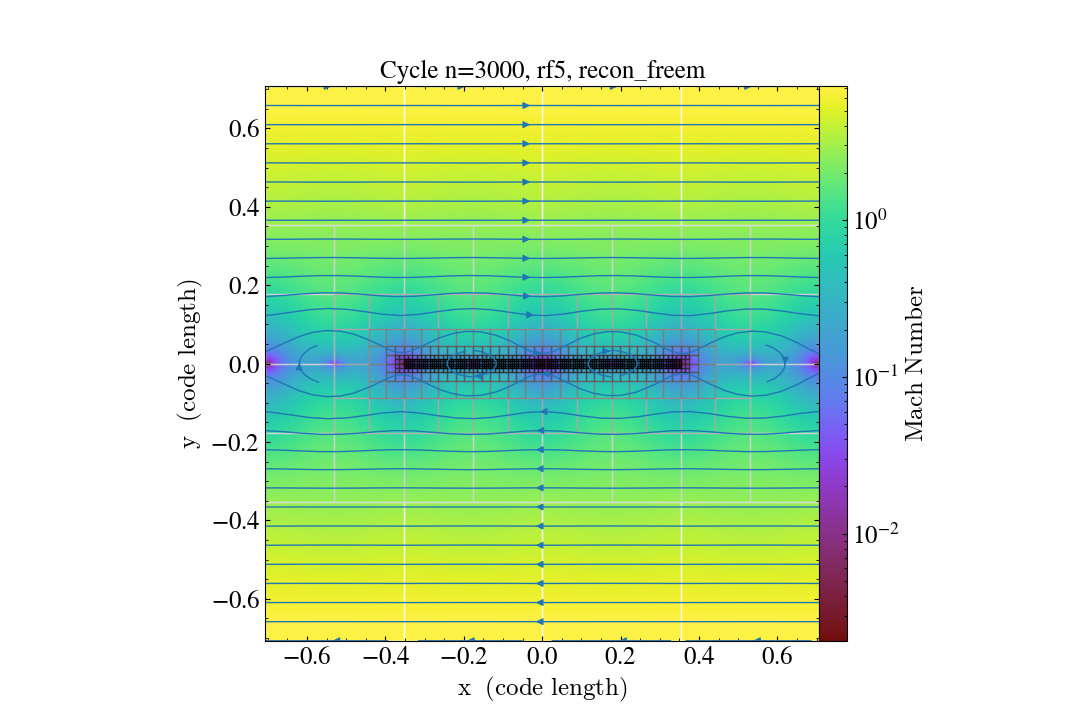

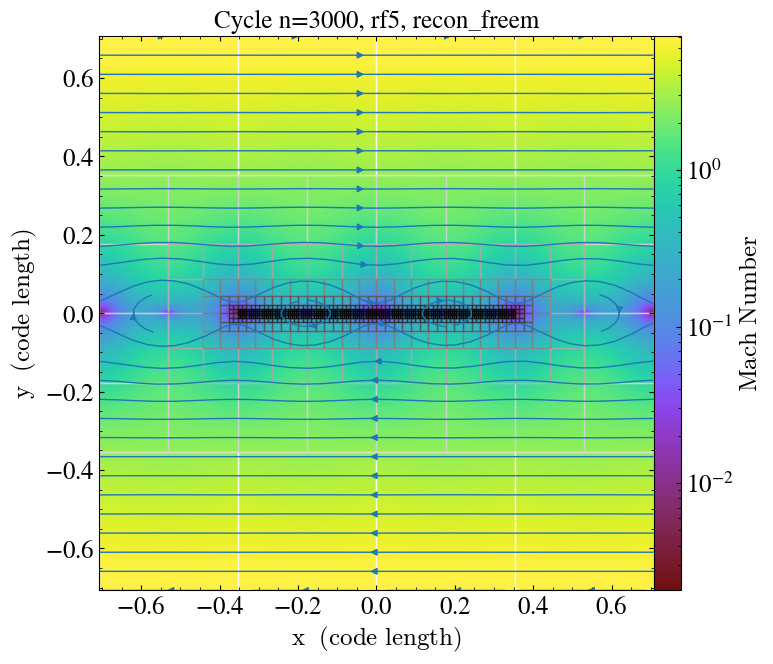

In [3]:
## Plotting a single dataset
index = 300
dictkey = "rf5"
basename = "recon_freem"
inputname = "athinput." + basename       # MagNoh2 for most problems
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename )# , outputnum="out3")
print(fileseries[index])
ts = yt.DatasetSeries(fileseries)
outputfreq = 10
ds = ts[index]

field = mach_number
p = yt.SlicePlot(ds, "z", field, window_size=(8,6))

# p.annotate_velocity()
p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"))

# p.set_log(field, False)
p.annotate_grids()

# p.pan([np.sqrt(2)/8, 0.0])
# p.zoom(10)

p.annotate_title(f'Cycle n={index*outputfreq}, {dictkey}, {basename}')
fig = p.export_to_mpl_figure((1,1))
# fig.axes[0].set_ylim(-0.004,0.004)
# fig.axes[0].set_box_aspect(0.333)
fig.savefig(f"figures/{dictkey}_t{index}_1x_IC.png")
p

/mnt/gs21/scratch/freem386/recon_GEM1/recon_GEM.out2.00000.athdf


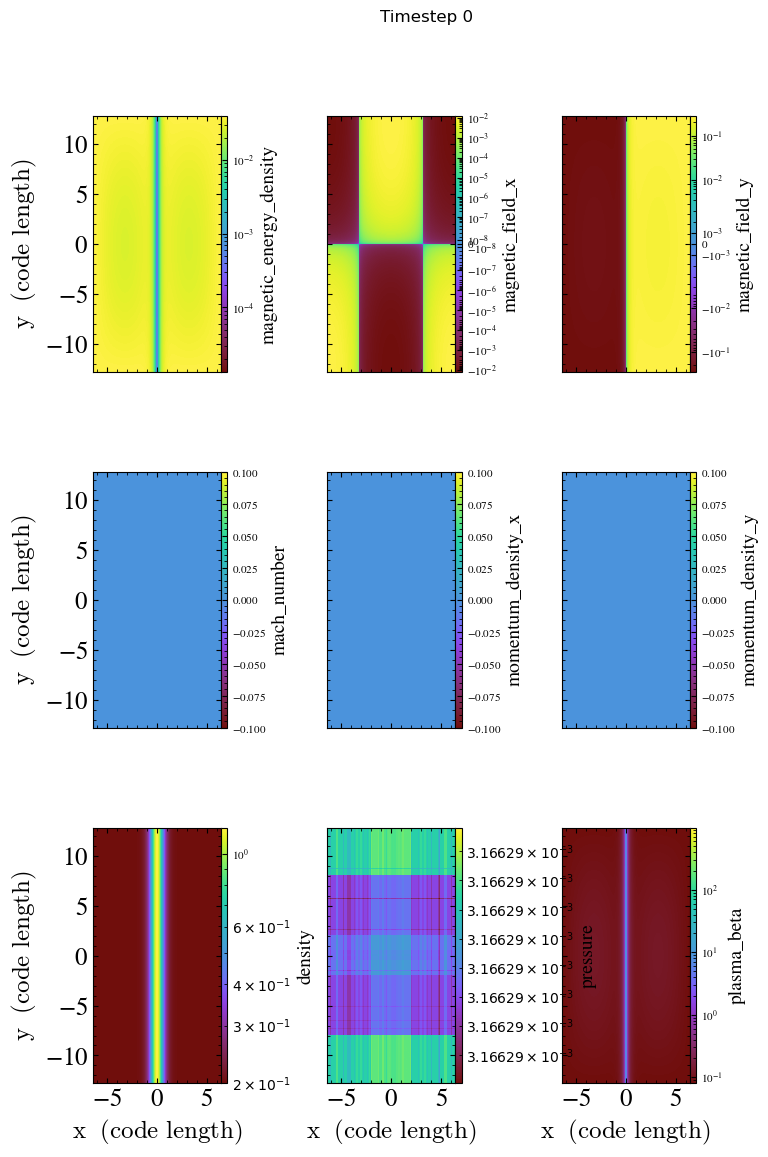

In [27]:
## Plotting multiple different fields
# Choose the dataset index
index = 0
dictkey = "rg1"
basename = "recon_GEM"
inputname = "athinput." + basename       # MagNoh2 for most problems
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)
print(fileseries[index])
ts = yt.DatasetSeries(fileseries)
ds = ts[index]
# p = yt.plot_2d(ds, ("athena_pp","press"))
# p.annotate_grids()
# p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"))

fields = [
('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'),
('gas', 'mach_number'), ('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'),
('gas', 'density'), ('gas', 'pressure'), ('gas', 'plasma_beta'), 
]
p = yt.SlicePlot(ds, "z", fields)
fig = p.export_to_mpl_figure((3, 3))
fig.suptitle("Timestep " + str(index))

# Adjust the layout
fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to prevent overlap with suptitle
fig.set_size_inches(12,12)
fig.subplots_adjust(wspace=0.05, hspace=0.01)  # Set small values for minimal spacing

# Iterate over each axis in the figure to modify the colorbar labels
for ax, field in zip(fig.axes, fields):
    if hasattr(ax, 'images') and ax.images:
        img = ax.images[0]
        cbar = img.colorbar
        if cbar is not None:
            # Set the font size for the colorbar labels
            cbar.ax.tick_params(labelsize=8)
            # Set the custom label for the colorbar
            cbar.set_label(field[1], fontsize=14)
            



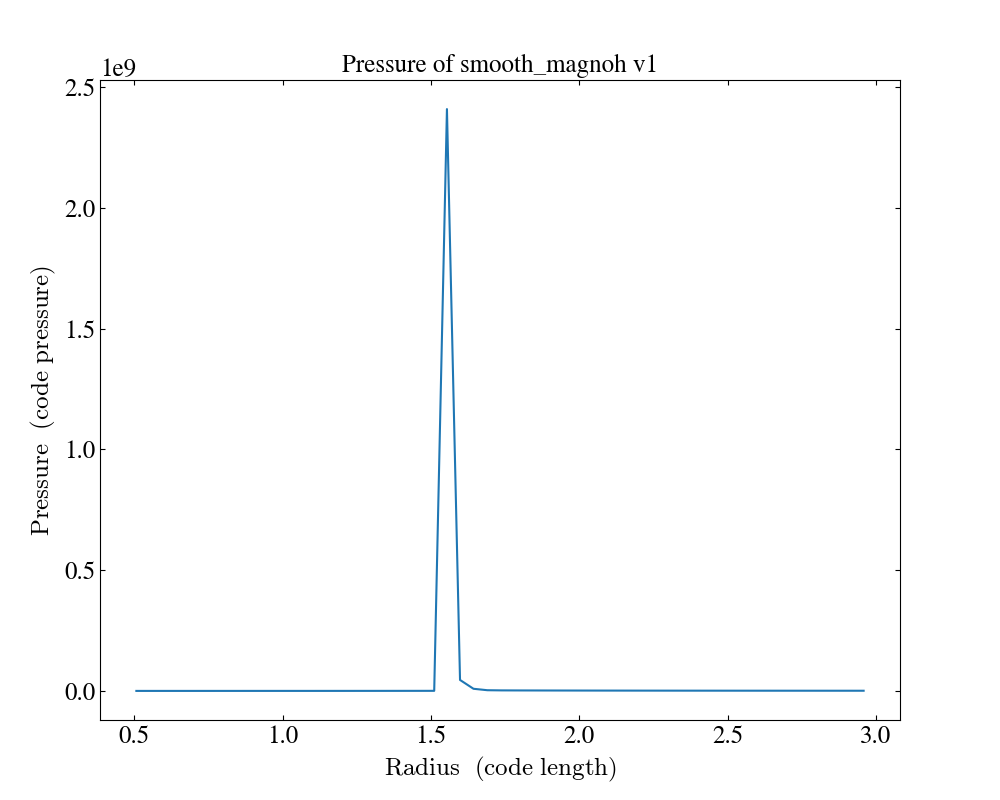

In [8]:
## Getting radial profiles
index = 1
dictkey = "magnoh_m18"
basename = 'magnoh_smooth'       # MagNoh2 for most problems
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename)
ts = yt.DatasetSeries(fileseries)
ds = ts[index]

field = pressure

my_sphere = ds.sphere("C", 3.0)

plot = yt.ProfilePlot(
    my_sphere,
    ("index", "radius"),
    field,
)

plot.set_log(("index", "radius"), False)
plot.set_log(field, False)
plot.annotate_title("Pressure of smooth_magnoh v1")
plot.save("figures/cycle1_smooth_v1.png")

plot.show()


# dims = (600, 600)

# all_data = ds.all_data()
# p = np.reshape(all_data[pressure], dims)[300, :]
# d = np.reshape(all_data[density], dims)[300, :]
# ux = np.reshape(all_data[momentum_x], dims)[300, :]

# x = np.linspace(-3.0, 3.0, 600)

# plt.plot(x, p, label="p")
# plt.plot(x, ux, label="ux")
# # plt.plot(x, d, label="d")
# plt.legend()
# plt.show()

In [35]:
plt.close("all")

In [6]:
## Grabbing raw np data from datasets
max_index = 1000
dictkey = "rg1"
basename = "recon_GEM"
step=15
fileseries = grabFileSeries(directoryDict[dictkey], max_index, basename=basename, step=15)

# cgrid = ds.all_data()
# pgrid = np.reshape(cgrid[field], (800, 1600))
# plt.plot(np.linspace(-500, 500, 1600), pgrid[:, 500])
# print(pgrid)


In [ ]:
## Todo check to see where the energy is being stored - thermal energy should spike and magnetic energy should dip if reconnection happens interestingly
ts = yt.DatasetSeries(fileseries)
ke_tot = np.zeros(max_index//step + 1)
me_tot = np.zeros(max_index//step + 1)
te_tot = np.zeros(max_index//step + 1)

for index in range(max_index//step + 1):
    print("{:.3f}".format(100*index*step/max_index), end='\r')
    # Calculating grid information for NP sums
    ds = ts[index]
    max_level = ds.index.max_level      # Max AMR level - included for if AMR is turned on later
    low = ds.domain_left_edge           # Domain left edge for numpy conversion starting region
    dims = ds.domain_dimensions         # Dimensions of full domain

    all_data_level_0 = ds.covering_grid(level=max_level, left_edge=low, dims=dims)
    ke_tot[index] = np.sum(all_data_level_0["gas", "kinetic_energy_density"])
    me_tot[index] = np.sum(all_data_level_0["gas", "magnetic_energy_density"])
    te_tot[index] = np.sum(all_data_level_0["gas", "pressure"])

In [16]:
## Dump energy totals... Deprecated
import pickle as pkl
pkl.dump(ke_tot, open(f"ke_tot_{dictkey}_{step}_{max_index}.pkl", 'wb'))
pkl.dump(me_tot, open(f"me_tot_{dictkey}_{step}_{max_index}.pkl", 'wb'))
pkl.dump(te_tot, open(f"te_tot_{dictkey}_{step}_{max_index}.pkl", 'wb'))

In [7]:
## Retrieve energy totals... Deprecated
import pickle as pkl
ke_tot = pkl.load(open(f"ke_tot_{dictkey}_{step}_{max_index}.pkl", 'rb'))
me_tot = pkl.load(open(f"me_tot_{dictkey}_{step}_{max_index}.pkl", 'rb'))
te_tot = pkl.load(open(f"te_tot_{dictkey}_{step}_{max_index}.pkl", 'rb'))

0.003166286988823053 code_pressure


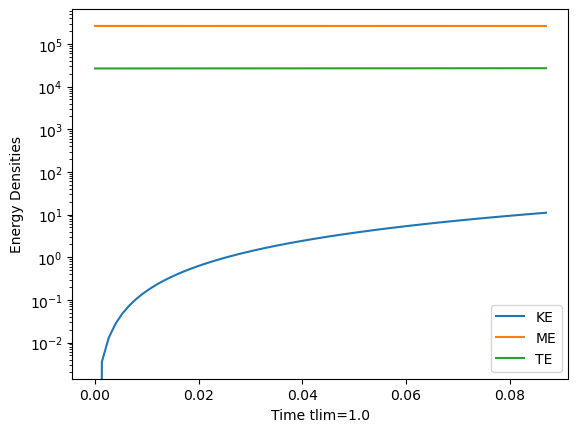

[0.00000000e+00 3.51154595e-03 1.28171343e-02 2.75969494e-02
 4.77478836e-02 7.32051454e-02 1.03921950e-01 1.39861821e-01
 1.80994838e-01 2.27295561e-01 2.78741780e-01 3.35313703e-01
 3.96993405e-01 4.63764440e-01 5.35611560e-01 6.12520500e-01
 6.94477819e-01 7.81470769e-01 8.73487202e-01 9.70515479e-01
 1.07254442e+00 1.17956321e+00 1.29156143e+00 1.40852893e+00
 1.53045586e+00 1.65733260e+00 1.78914978e+00 1.92589821e+00
 2.06756891e+00 2.21415306e+00 2.36564197e+00 2.52202715e+00
 2.68330019e+00 2.84945282e+00 3.02047690e+00 3.19636438e+00
 3.37710730e+00 3.56269781e+00 3.75312814e+00 3.94839058e+00
 4.14847753e+00 4.35338145e+00 4.56309484e+00 4.77761029e+00
 4.99692044e+00 5.22101799e+00 5.44989568e+00 5.68354632e+00
 5.92196274e+00 6.16513785e+00 6.41306457e+00 6.66573587e+00
 6.92314476e+00 7.18528429e+00 7.45214753e+00 7.72372761e+00
 8.00001766e+00 8.28101086e+00 8.56670041e+00 8.85707955e+00
 9.15214162e+00 9.45187995e+00 9.75628787e+00 1.00653587e+01
 1.03790858e+01 1.069746

In [12]:
## Plotting energy over time
index = 0
ds = ts[index]
max_level = ds.index.max_level      # Max AMR level - included for if AMR is turned on later
low = ds.domain_left_edge           # Domain left edge for numpy conversion starting region
dims = ds.domain_dimensions         # Dimensions of full domain

all_data_level_0 = ds.covering_grid(level=max_level, left_edge=low, dims=dims)
print(all_data_level_0["gas", "pressure"].min())

t = np.arange(0, max_index, step) * 8.78906e-05
plt.plot(t, ke_tot, label='KE')
plt.plot(t, me_tot, label="ME")
plt.plot(t, te_tot, label="TE")
plt.yscale("log")
plt.legend()
plt.ylabel("Energy Densities")
plt.xlabel("Time tlim=1.0")

plt.show()
print(ke_tot)

## Field list output from magpinch problems:
('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3'),
('athena_pp', 'cell_volume'),
('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz'),
('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z'),
('athena_pp', 'press'),
('athena_pp', 'rho'),
('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3'),
('athena_pp', 'volume'),
('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z'),
('gas', 'alfven_speed'),
('gas', 'angular_momentum_magnitude'),
('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z'),
('gas', 'averaged_density'),
('gas', 'baroclinic_vorticity_magnitude'),
('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z'),
('gas', 'cell_mass'), ('gas', 'cell_volume'),
('gas', 'courant_time_step'),
('gas', 'density'),
('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z'),
('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz'),
('gas', 'four_velocity_magnitude'), ('gas', 'four_velocity_t'), ('gas', 'four_velocity_x'), ('gas', 'four_velocity_y'), ('gas', 'four_velocity_z'),
('gas', 'jeans_mass'),
('gas', 'kT'),
('gas', 'kinetic_energy_density'),
('gas', 'lorentz_factor'),
('gas', 'mach_alfven'), ('gas', 'mach_number'),
('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude'),
('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z'),
('gas', 'magnetic_pressure'),
('gas', 'mass'), ('gas', 'mean_molecular_weight'),
('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z'),
('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z'),
('gas', 'number_density'),
('gas', 'path_element_x'), ('gas', 'path_element_y'), ('gas', 'path_element_z'),
('gas', 'plasma_beta'),
('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z'),
('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z'),
('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z'),
('gas', 'shear'), ('gas', 'shear_criterion'), 
('gas', 'shear_mach'), ('gas', 'sound_speed'),
('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z'),
('gas', 'specific_thermal_energy'),
('gas', 'temperature'),
('gas', 'velocity_los'),
('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z'),
('gas', 'volume'),
('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared'),
('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z'),
('gas', 'x'), ('gas', 'y'), ('gas', 'z'),
('index', 'cell_volume'),
('index', 'cylindrical_radius'),
('index', 'cylindrical_theta'),
('index', 'cylindrical_z'),
('index', 'dx'), ('index', 'dy'), ('index', 'dz'),
('index', 'grid_indices'), ('index', 'grid_level'),
('index', 'morton_index'),
('index', 'ones'), ('index', 'ones_over_dx'),
('index', 'path_element_x'), ('index', 'path_element_y'), ('index', 'path_element_z'),
('index', 'radius'), ('index', 'spherical_phi'), ('index', 'spherical_radius'), ('index', 'spherical_theta'),
('index', 'virial_radius_fraction'),
('index', 'volume'),
('index', 'x'), ('index', 'y'), ('index', 'z'), 
('index', 'zeros')

Old Dictionary Definitions that I'm keeping because I'm nostalgic

'zero_res': "simple_magpinch_zero_resistivity/",
                 'smallest_res': "simple_magpinch_smallest_resistivity/",
                 'small_res': "simple_magpinch_small_resistivity/",
                 'medium_res': "simple_magpinch_medium_resistivity/",
                 'large_res': "simple_magpinch_large_resistivity/",
                 'large_res_high_res': "simple_magpinch_animation2/",
                 'test1': "test1/", 'test2': "test2/", 'test3': "test3/", 'test4': "test4/",
                 'magnohverify': "magnoh_verification/", 'magnohcopyverify': "magnoh_copy_verification/",
                 'magnoh_m1': "magnoh_modification1/", 'magnoh_m2': "magnoh_modification2/",
                 'magnoh_m3': "magnoh_modification3/", 'magnoh_m4': "magnoh_modification4/",
                 'magnoh_m5': "magnoh_modification5/", 'magnoh_m6': "magnoh_modification6/",
                 'magnoh_m7': "magnoh_modification7/", 'magnoh_m8': "magnoh_modification8/",
                 'magnoh_m9': "magnoh_modification9/", 'magnoh_m10': "magnoh_modification10/",
                 'magnoh_m11': "magnoh_modification11/", 'magnoh_m12': "magnoh_modification12/",
                 'magnoh_m13': "magnoh_modification13/", 'magnoh_m14': "magnoh_modification14/",
                 'magnoh_m15': "magnoh_modification15/", 'magnoh_m16': "magnoh_modification16/",
                 'magnoh_m17': "magnoh_modification17/", 'magnoh_m18': "magnoh_modification18/",
                 'pspace1': "reimann_parameterspace/", 'pspace2': "reimann_parameterspace2/",
                 'roe1': "roe_pspace1/",
                 'stock_roe': "stock_roe_magnoh/", 'stock_hlle': "stock_hlle_magnoh/",
                 'stock_hlld': "stock_hlld_magnoh/", 'stock_lhlld': "stock_lhlld_magnoh/",
                 'lhlld1': "lhlld_pspace1/", 'lhlld2': "lhlld_pspace2/"

In [34]:
## Adding missing kinetic/magnetic/pressure ratios and current that are missing in YT 
def _KEoverME(field, data):
    return (
        data["gas", "kinetic_energy_density"] / data["gas", "magnetic_energy_density"]
    )
    
def _KEoverTE(field, data):
    return (
        data["gas", "kinetic_energy_density"] / data["gas", "pressure"]
    )
    
def _current_eta_z(field, data):
    # u = data["gas", "velocity_x"], data["gas", "velocity_y"], data["gas", "velocity_z"]
    # b = data["gas", "magnetic_field_x"], data["gas", "magnetic_field_y"], data["gas", "magnetic_field_z"]
    B = np.stack((data["gas", "magnetic_field_x"], data["gas", "magnetic_field_y"], data["gas", "magnetic_field_z"]), axis=-1)
    U = np.stack((data["gas", "velocity_x"], data["gas", "velocity_y"], data["gas", "velocity_z"]), axis=-1)
    J = yt.units._numpy_wrapper_functions.ucross(U, B, registry=data.ds.unit_registry)
    return J[:, 2]

yt.add_field(
    name=("gas", "current_eta_z"),
    function=_current_eta_z,
    sampling_type="local",
    units="dimensionless",
    force_override=True,
)
    
yt.add_field(
    name=("gas", "KEoverME"),
    function=_KEoverME,
    sampling_type="local",
    units="code_pressure/code_pressure",
    force_override=True,
)

yt.add_field(
    name=("gas", "KEoverTE"),
    function=_KEoverTE,
    sampling_type="local",
    units="code_pressure/code_pressure",
    force_override=True,
)

In [61]:
ds.derived_field_list

[('athena_pp', 'Bcc1'),
 ('athena_pp', 'Bcc2'),
 ('athena_pp', 'Bcc3'),
 ('athena_pp', 'cell_volume'),
 ('athena_pp', 'dx'),
 ('athena_pp', 'dy'),
 ('athena_pp', 'dz'),
 ('athena_pp', 'path_element_x'),
 ('athena_pp', 'path_element_y'),
 ('athena_pp', 'path_element_z'),
 ('athena_pp', 'press'),
 ('athena_pp', 'rho'),
 ('athena_pp', 'vel1'),
 ('athena_pp', 'vel2'),
 ('athena_pp', 'vel3'),
 ('athena_pp', 'volume'),
 ('athena_pp', 'x'),
 ('athena_pp', 'y'),
 ('athena_pp', 'z'),
 ('gas', 'alfven_speed'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'baroclinic_vorticity_magnitude'),
 ('gas', 'baroclinic_vorticity_x'),
 ('gas', 'baroclinic_vorticity_y'),
 ('gas', 'baroclinic_vorticity_z'),
 ('gas', 'cell_mass'),
 ('gas', 'cell_volume'),
 ('gas', 'courant_time_step'),
 ('gas', 'density'),
 ('gas', 'density_gradient_magnitude'),
 ('gas', 'density_gradient_x'),
 ('g